In [1]:
import os
import gc
import sys
import pandas as pd
import numpy as np
import seaborn as sns 
import random
import time
import json
from lightgbm import LGBMClassifier, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from IPython.display import clear_output
from matplotlib import pyplot as plt

In [2]:
## plug in gdrive to load the data from gdrive
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
## Load dataset
path = '/content/drive/MyDrive/Fellowship_Deep_and_Wide_Bandit/Test_Dataset/'

## Using 1% selected data
train_df = pd.read_csv(path+'train_sample_2020.csv')
valid_df = pd.read_csv(path+'valid_sample_2020.csv')
test_df = pd.read_csv(path+'test_sample_2020.csv')

In [4]:
user_col = ['riid']
context_col = ['retention_score','frequency_score','recency_score', 
               'sends_since_last_open', 'days_subscr', 'discount', 'promo', 
               'sale', 'is_one_for_free', 'is_exclusive','has_urgency',
               'sl_contains_price', 'is_discount_mentioned', 'sent_week', 'sent_dayofweek', 'sent_hr']
rewards_col = ['reward']
action_col = ['optimal_action']

In [5]:
num_actions = 2 ## Send email or not send
num_features = len(context_col)
num_users = train_df[user_col].nunique()[0] + 1
print("Number of actions:", num_actions)
print("Number of features:", num_features)
print("Number of users:", num_users)
print("Number of rows (train):", len(train_df))
print("Number of rows (valid):", len(valid_df))

Number of actions: 2
Number of features: 16
Number of users: 227493
Number of rows (train): 276776
Number of rows (valid): 83389


In [6]:
### Train with LightGBM

def train_lgbm_model(X_train, X_test, y_train, y_test, prints=True):
    
    #X_train = cupy.asnumpy(X_train.as_gpu_matrix())
    #X_test = cupy.asnumpy(X_test.as_gpu_matrix())
    #y_train = cupy.asnumpy(y_train)
    #y_test = np.int32(cupy.asnumpy(y_test))
    
    lgbm = LGBMClassifier(
        boosting_type='gbdt',
        num_leaves=30, 
        max_depth= -1, 
        n_estimators = 100, 
        min_child_samples = 20, 
    )

    model = lgbm.fit(X_train, y_train)

    #print("ytest = ", y_test[110:120])
    #print("ypred = ", model.predict(X_test)[110:120])
    #print("ypred_prob = ", model.predict_proba(X_test)[0:10])
    
    roc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])

    if prints:
        print("ROC: {:.5}".format(roc))
    
    return model, roc

In [7]:
%%time

X_train = train_df[context_col]
y_train = train_df[action_col]
X_valid = valid_df[context_col]
y_valid = valid_df[action_col]

model, roc = train_lgbm_model(X_train, X_valid, y_train, y_valid)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ROC: 0.86117
CPU times: user 6.76 s, sys: 42.6 ms, total: 6.8 s
Wall time: 3.57 s


(array([44395., 14930.,  6620.,  4349.,  3053.,  2426.,  1920.,  1612.,
         1816.,  2268.]),
 array([0.01104763, 0.10691695, 0.20278627, 0.2986556 , 0.39452492,
        0.49039424, 0.58626356, 0.68213289, 0.77800221, 0.87387153,
        0.96974085]),
 <a list of 10 Patch objects>)

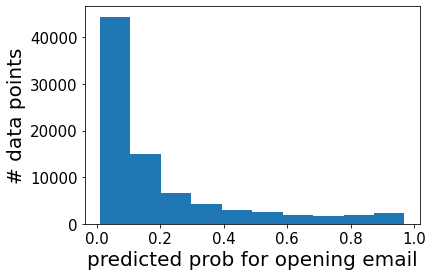

In [8]:
ypred_prob = model.predict_proba(X_valid)

## Histogram of probabilities
plt.figure(figsize=(6,4))
#plt.title('Histogram % email opened', size = 20)
plt.xlabel('predicted prob for opening email', size = 20)
plt.ylabel('# data points', size = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.hist(ypred_prob[:,1], 10)

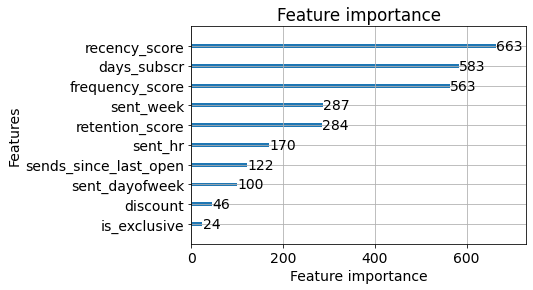

In [42]:
plot_importance(model, importance_type='split', max_num_features=10)

In [20]:
def evaluate_model(model, test_df, context_col, action_col, prob_thresh=0.5, 
                   plot_confusion_matrix=True, print_results=True):
  X_test = test_df[context_col]
  y_true = test_df[action_col]
  y_pred_prob = np.array(model.predict_proba(X_test)[:,1])

  idx_1 = np.where(y_pred_prob >= prob_thresh)
  idx_0 = np.where(y_pred_prob < prob_thresh)

  y_pred = y_pred_prob
  y_pred[idx_1[0]] = 1
  y_pred[idx_0[0]] = 0

  cf_matrix = confusion_matrix(y_true,y_pred)

  cf_matrix_flat = cf_matrix.flatten()
  n_sample = len(y_true)
  TN = cf_matrix_flat[0]/n_sample
  FP = cf_matrix_flat[1]/n_sample
  FN = cf_matrix_flat[2]/n_sample
  TP = cf_matrix_flat[3]/n_sample

  #print("True negatives = ", TN)
  #print("False negatives = ", FN)
  #print("True positives = ", TP)
  #print("False positives = ", FP)

  precision = TP/(TP+FP) 
  recall = TP/(TP+FN) 
  accuracy = (TN + TP) 
  f1_score = 2*precision*recall/(precision+recall)

  if print_results:
    print(f"Accuracy = {accuracy * 100:.2f}%")
    print(f"Precision = {precision * 100:.2f}%")
    print(f"Recall = {recall * 100:.2f}%")
    print(f"F1 Score = {f1_score:.2f}")

  if plot_confusion_matrix:
    group_names = ["Don't Send (T)","Send (F)","Don't Send (F)","Send (T)"]

    group_percentages = ["{0:.2%}".format(value) for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    ax = plt.axes()
    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=labels, 
              fmt='', cmap='Blues',annot_kws={"fontsize":16}, ax = ax)
    ax.set_title('Confusion Matrix')
    plt.show()

  return accuracy, precision, recall, f1_score




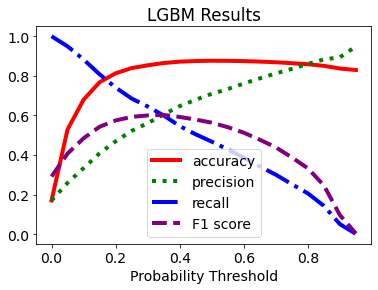

In [43]:
accuracy = []
precision = []
recall = []
f1_score = []
prob_thresholds = []

for i in range(20):
  prob_thresh = i * 0.05
  acc, pre, re, f1 = evaluate_model(model, test_df, context_col, action_col, prob_thresh=prob_thresh, 
                                    plot_confusion_matrix=False, print_results=False)
  accuracy.append(acc)
  precision.append(pre)
  recall.append(re)
  f1_score.append(f1)
  prob_thresholds.append(prob_thresh)

# multiple line plots
plt.rc('font', size=14)
ax = plt.axes()
ax.plot(prob_thresholds, accuracy, color='red', linewidth=4, label='accuracy')
ax.plot(prob_thresholds, precision, color='green', linewidth=4, linestyle='dotted', label='precision')
ax.plot(prob_thresholds, recall, color='blue', linewidth=4, linestyle='dashdot', label='recall')
ax.plot(prob_thresholds, f1_score, color='purple', linewidth=4, linestyle='dashed', label='F1 score')
ax.set_title('LGBM Results')
ax.set_xlabel('Probability Threshold')
plt.legend()
plt.show()

Accuracy = 86.47%
Precision = 60.48%
Recall = 60.00%
F1 Score = 0.60


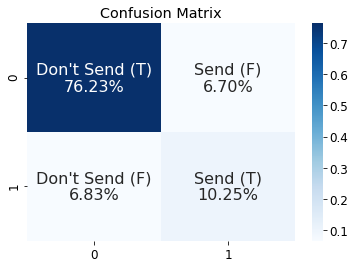

In [37]:
_,_,_,_ = evaluate_model(model, test_df, context_col, action_col, prob_thresh=0.35)

Accuracy = 81.27%
Precision = 46.94%
Recall = 74.11%
F1 Score = 0.57


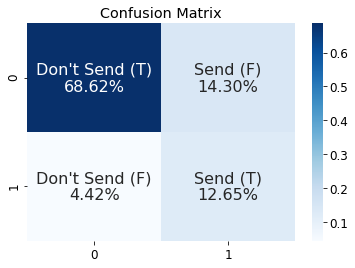

In [40]:
_,_,_,_ = evaluate_model(model, test_df, context_col, action_col, prob_thresh=0.2)